# Laboratorium 3

### Konfiguracja

In [15]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import random
import heapq
import functools
from sortedcontainers import SortedSet
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [16]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


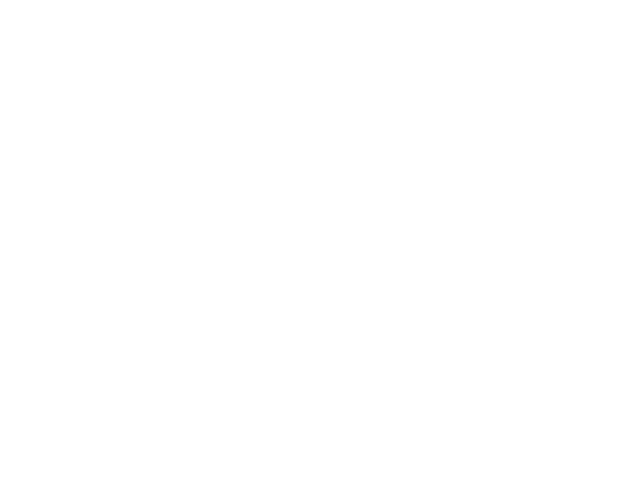

In [17]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


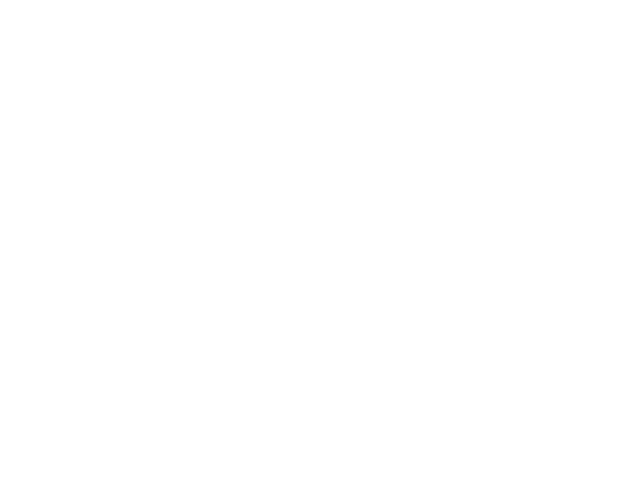

In [18]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


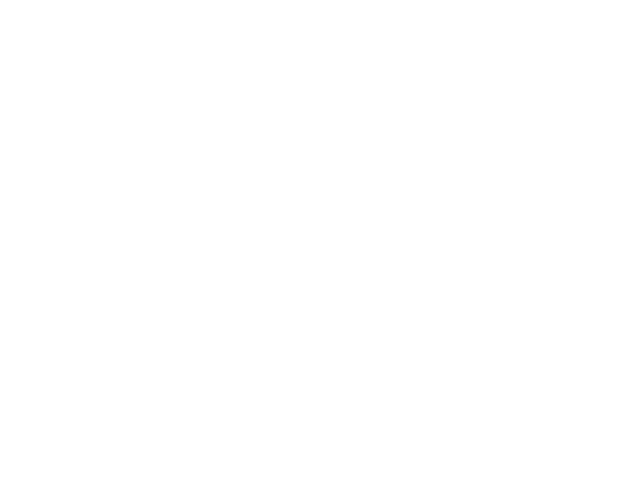

In [19]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot([Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])])
plot1.draw()

<IPython.core.display.Javascript object>


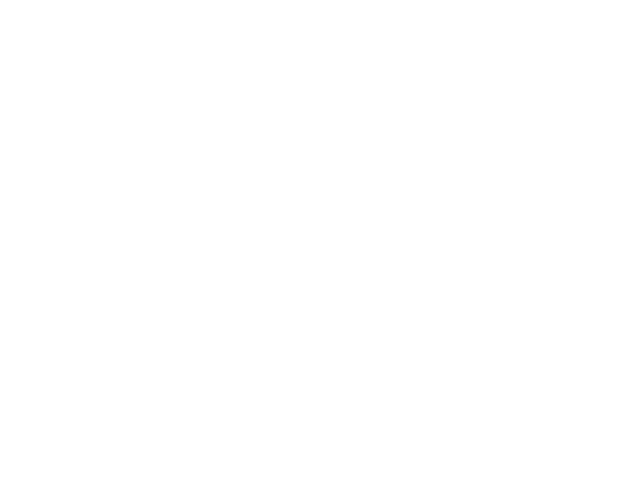

In [20]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

# Generowanie lini v1

In [44]:
def get_slope(p):
    return (p[1][1] - p[0][1]) / (p[1][0] - p[0][0])


def generate_lines_v1(lower_left=(0, 0), upper_right=(10, 10), amount=10):
    points = []
    for i in range(0, amount):
        p0 = (random.uniform(lower_left[0], upper_right[0]), random.uniform(lower_left[1], upper_right[1]))
        p1 = (random.uniform(lower_left[0], upper_right[0]), random.uniform(lower_left[1], upper_right[1]))
        if p0[1] == p1[1]:
            i = i - 1
            continue
        if p0[0] < p1[0]:
            points.append((p0, p1))
        else:
            points.append((p1, p0))
    points.sort(key=lambda p: get_slope(p))
    points_distinct = [points[0]]
    for i in range(1, len(points)):
        a1 = get_slope(points[i - 1])
        b1 = points[i - 1][1][1] - a1 * points[i - 1][1][0]
        a2 = get_slope(points[i])
        b2 = points[i][1][1] - a2 * points[i][1][0]
        if a1 != a2 and b1 != b2:
            points_distinct.append(points[i])

    return points_distinct

<IPython.core.display.Javascript object>


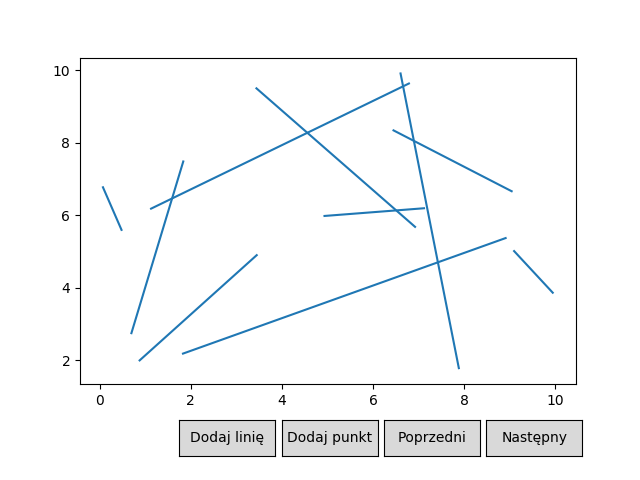

In [45]:
%matplotlib notebook
plot1 = Plot([Scene([PointsCollection([])], 
              [LinesCollection(generate_lines_v1())])])
plot1.draw()


In [46]:
def det_3x3(a, b, c):
    a = (a[0], a[1], 1)
    b = (b[0], b[1], 1)
    c = (c[0], c[1], 1)
    return a[0] * b[1] * c[2] + a[1] * b[2] * c[0] + a[2] * b[0] * c[1] - a[2] * b[1] * c[0] - a[1] * b[0] * c[2] - a[
        0] * b[2] * c[1]


def orient(a, b, c, epsilon=10e-10):
    det = det_3x3(a, b, c)
    if det > epsilon:
        return 1
    if det < -epsilon:
        return -1
    else:
        return det

# Wykrywanie jednego punktu przecięcia

In [49]:
class SweepLineStatusV1:
    def __init__(self, dataset, scenes =[]):
        super().__init__()
        self.scenes = scenes
        self.lines = SortedSet(key=lambda x: x[0][1])
        self.events = []
        self.dataset = dataset
        for p in dataset:
            self.events.append((p[0][0], p))
            self.events.append((p[1][0], p))
        heapq.heapify(self.events)

    def find_intersection(self, line1, line2):
        p1 = line1[0]
        q1 = line1[1]
        p2 = line2[0]
        q2 = line2[1]
        return orient(p1, q1, p2) != orient(p1, q1, q2) and orient(p2, q2, p1)!=orient(p2, q2, q1)

    def run(self):
        while self.events:
            if self.event_happened(heapq.heappop(self.events)):
                print('przynajmniej jedna para lini sie przecina')
                break
    
    def insert_line(self, line):
        self.lines.add(line)
        i = self.lines.index(line)
        if i-1>=0:
            return self.find_intersection(self.lines[i-1], line)
        if i+1<len(self.lines):
            return self.find_intersection(self.lines[i+1], line)

    def remove_line(self, line):
        i = self.lines.index(line)
        if i-1>=0 and i+1<len(self.lines):
            return self.find_intersection(self.lines[i-1], self.lines[i+1])
        self.lines.remove(line)

    def event_happened(self, event):
        if event[0] == event[1][0][0]:
            self.scenes.append(Scene(
                [PointsCollection([event[1][0]])],
                [LinesCollection(list(self.dataset)), LinesCollection([ ((event[0], 0), (event[0], 10)) ], color='red')]
            ))
            return self.insert_line(event[1])
        else:
            self.scenes.append(Scene(
                [PointsCollection([event[1][1]])],
                [LinesCollection(list(self.dataset)), LinesCollection([ ((event[0], 0), (event[0], 10)) ], color='red')]
            ))
            return self.remove_line(event[1])

przynajmniej jedna para lini sie przecina


<IPython.core.display.Javascript object>


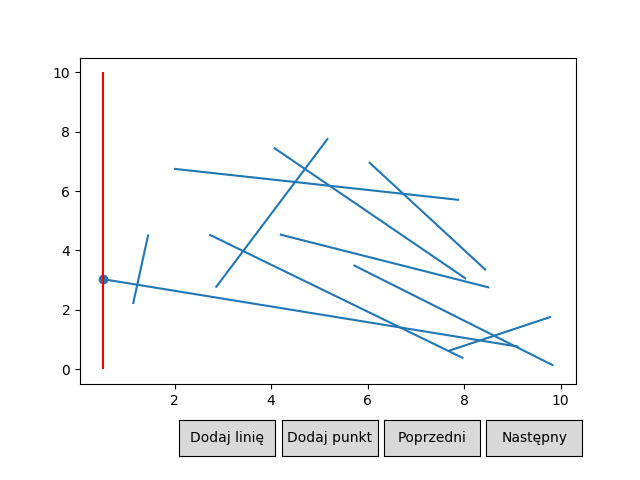

In [50]:
%matplotlib notebook
dataset = generate_lines_v1()
scenes = []
sweeper = SweepLineStatusV1(dataset, scenes)
sweeper.run()
plot1 = Plot(scenes)
plot1.draw()

# Wykrywanie wszystkich punktów przecięcia

In [28]:
class Point:

    def __init__(self, x: float, y: float) -> None:
        super().__init__()
        self.x = x
        self.y = y

    def add_intersecting_lines(self, line1:'Line', line2:'Line'):
        self.line1=line1
        self.line2=line2

    def get_y(self, x):
        return self.y

    def __eq__(self, other):
        return isinstance(other, Point) and self.x == other.x and self.y == other.y

    def __hash__(self):
        return self.x.__hash__()*self.y.__hash__()

    def __gt__(self, other):
        return isinstance(other, Point) and self.x > other.x

    def __ge__(self, other):
        return isinstance(other, Point) and self.x >= other.x

    def __le__(self, other):
        return isinstance(other, Point) and self.x <= other.x

    def __lt__(self, other):
        return isinstance(other, Point) and self.x < other.x

    def __str__(self):
        return '(' + str(self.x) + ', ' + str(self.y) + ')'
    
    def to_tuple(self):
        return self.x, self.y

class Line:

    def __init__(self, p0: Point, p1: Point) -> None:
        super().__init__()
        if p0.x < p1.x:
            self.p0 = p0
            self.p1 = p1
        else:
            self.p0 = p1
            self.p1 = p0

    def get_left(self):
        return self.p0

    def get_right(self):
        return self.p1

    def get_slope(self):
        return (self.p1.y - self.p0.y) / (self.p1.x - self.p0.x)

    def get_b(self):
        return self.p1.y - self.get_slope() * self.p1.x

    def get_y(self, x: float):
        return self.get_slope() * x + self.get_b()

    def check_colinearity(self, line: 'Line'):
        a1 = self.get_slope()
        b1 = self.get_b()
        a2 = line.get_slope()
        b2 = line.get_b()
        return a1 != a2 and b1 != b2

    def __str__(self):
        return '(' + str(self.p0) + ', ' + str(self.p1) + ')'

    def to_tuple(self):
        return self.get_left().to_tuple(), self.get_right().to_tuple()


def generate_lines(lower_left: Point = Point(0, 0), upper_right: Point = Point(10, 10), amount=10):
    lines = []
    for i in range(0, amount):
        p0 = Point(random.uniform(lower_left.x, upper_right.x), random.uniform(lower_left.y, upper_right.y))
        p1 = Point(random.uniform(lower_left.x, upper_right.x), random.uniform(lower_left.y, upper_right.y))
        if p0.y == p1.y:
            i = i - 1
            continue
        lines.append(Line(p0, p1))
    lines.sort(key=lambda l: l.get_slope())
    lines_distinct = [lines[0]]
    for i in range(1, len(lines)):
        if lines[i - 1].check_colinearity(lines[i]):
            lines_distinct.append(lines[i])
    return lines_distinct


def line_intersection(line1: Line, line2: Line):
    xdiff = line1.get_left().x - line1.get_right().x, line2.get_left().x - line2.get_right().x
    ydiff = line1.get_left().y - line1.get_right().y, line2.get_left().y - line2.get_right().y

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1.to_tuple()), det(*line2.to_tuple()))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    if line1.get_left().x < x < line1.get_right().x and \
            line2.get_left().x < x < line2.get_right().x:
        point = Point(x,y)
        point.add_intersecting_lines(line1, line2)
        return point
    return None


class SweepLineStatus:
    def __init__(self, scenes=[]):
        super().__init__()
        self.lines:SortedSet = SortedSet()
        self.events: SortedSet = SortedSet(key=lambda p:-p.x)
        self.scenes = scenes
        self.dataset = {}
        self.results = set([])

    def run(self, dataset: List[Line]):
        for l in dataset:
            self.dataset[l.get_left()] = l
            self.dataset[l.get_right()] = l
            self.events.add(l.get_left())
            self.events.add(l.get_right())
        smallest_y = functools.reduce(lambda acc, p: p if p.y<acc.y else acc, self.dataset.keys()).y
        biggest_y = functools.reduce(lambda acc, p: p if p.y>acc.y else acc, self.dataset.keys()).y
        self.update_keys(self.events[0].x)
        while len(self.events)>0:
            event = self.events.pop()
    
            self.scenes.append(Scene(
                                [PointsCollection([event.to_tuple()], color='red'), PointsCollection(list(map(lambda l: l.to_tuple(), self.results)))],
                                [LinesCollection(list(map(lambda l: l.to_tuple(), dataset))), LinesCollection([ ((event.x, smallest_y), (event.x, biggest_y)) ], color='red')]
                ))
            
            self.event_happened(event)
        return self.results

    def find_intersection(self, line1: Line, line2: Line):
        return line_intersection(line1, line2)

    def insert_line(self, line: Line):
        self.lines.add(line)
        i = self.lines.index(line)

        if i - 1 >= 0 and i + 1 < len(self.lines):
            intersection = self.find_intersection(self.lines[i - 1], self.lines[i + 1])
            if intersection is not None and intersection in self.events:
                self.events.remove(intersection)
        if i - 1 >= 0:
            intersection = self.find_intersection(self.lines[i - 1], line)
            if intersection is not None and intersection not in self.results and intersection not in self.events:
                self.events.add(intersection)
        if i + 1 < len(self.lines):
            intersection = self.find_intersection(line, self.lines[i + 1])
            if intersection is not None and intersection not in self.results and intersection not in self.events:
                self.events.add(intersection)

    def remove_line(self, line: Line):
        i = self.lines.index(line)
        if i - 1 >= 0 and i + 1 < len(self.lines):
            intersection = self.find_intersection(self.lines[i - 1], self.lines[i + 1])
            if intersection is not None and intersection not in self.results:
                self.events.add(intersection)
        self.lines.remove(line)

    def intersection_event(self, intersection: Point):
        self.results.add(intersection)
        line1 = intersection.line1
        line2 = intersection.line2

        self.remove_line(line1)
        self.remove_line(line2)

        self.update_keys(intersection.x + 0.01)

        self.insert_line(line1)
        self.insert_line(line2)

    def update_keys(self, x):
        temp_lines = SortedSet(key=lambda l: l.get_y(x))
        temp_lines.update(self.lines)
        self.lines = temp_lines

    def event_happened(self, event: Point):
        if event in self.dataset:
            line = self.dataset[event]
            if event == line.get_left():
                self.update_keys(event.x)
                self.insert_line(line)
            else:
                self.update_keys(event.x)
                self.remove_line(line)
        else:
            self.intersection_event(event)



ilość punktów przecięć: 26
punkt: (4.058140397995228, 4.4266453101573315)
linie: ((0.3161269934349775, 2.072220063676805), (5.876797783806188, 5.5709204371874534)) ((3.5391275484441542, 6.150845972916702), (4.954772180740797, 1.4479654655287522))
punkt: (7.3345099393435795, 2.705857796384593)
linie: ((6.655723041771128, 0.6437627597819262), (9.136360496139067, 8.179721689685715)) ((1.9789778135282077, 9.336036574001819), (7.631710880726902, 2.3379213658011313))
punkt: (5.437604968778922, 5.054236777881156)
linie: ((1.7404536365738943, 3.827754580427656), (5.791843938803599, 5.171750980395665)) ((1.9789778135282077, 9.336036574001819), (7.631710880726902, 2.3379213658011313))
punkt: (1.2783500296131542, 6.728706275457479)
linie: ((0.526560332845587, 1.179286903710678), (1.360861958641969, 7.337777268743877)) ((1.1280777183219182, 6.693466147474104), (2.596258341117, 7.037766921219032))
punkt: (4.137467274585939, 4.1631153160336005)
linie: ((1.3993330958220085, 1.583120282394066), (8.108

<IPython.core.display.Javascript object>


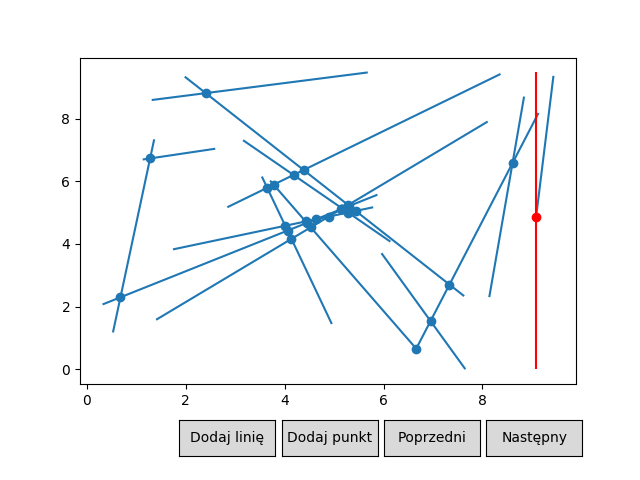

In [29]:

%matplotlib notebook
scenes = []
sweep = SweepLineStatus(scenes=scenes)
dataset = generate_lines(amount = 15)
result = sweep.run(dataset)
print('ilość punktów przecięć: ' + str(len(result)))
for p in result:
    print('punkt: ' + str(p))
    print('linie: ' + str(p.line1) + ' ' + str(p.line2))
plot = Plot(scenes)
plot.draw()